In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
from itertools import combinations
from collections import Counter

In [2]:
np.random.seed(42)
df = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_qna_results/final_results_with_accuracy_updated.csv')
df.head()

,case_id,mode,case_type,iteration,Q0_answer,Q0_reasoning,Q1_answer,Q1_reasoning,Q2_answer,Q2_reasoning,...,adjusted_correct,adjusted_total,adjusted_accuracy,adjusted_wrong_questions,adjusted_wrong_predictions,adjusted_ground_truth,unclear_count,unclear_questions,not_answerable_count,not_answerable_questions
0,Case3223,baseline,without_policy,iter2,BRCA1/2,Request was specifically for BRCA1 and BRCA2 t...,Not Specified,BCBS_FEP BRCA coverage criteria are based on p...,Not Specified,BCBS_FEP policies specify requirements around ...,...,4,5,80.000000,Q3,Q3:Yes,Q3:No,0,NaN,0,NaN
1,Case14226,baseline,without_policy,iter2,BRCA1/2,The clinical note explicitly states germline B...,Not Specified,Cigna BRCA testing policy does not impose a sp...,Not Specified,Cigna typically requires an appropriate orderi...,...,5,6,83.333333,Q7,Q7:81277,Q7:81162,0,NaN,0,NaN
2,Case10451,baseline,without_policy,iter2,WES,The clinical note explicitly states the neurol...,Yes,UHC coverage for WES includes pediatric patien...,Not Specified,UHC policies generally require an appropriatel...,...,5,5,100.000000,NaN,NaN,NaN,0,NaN,1,Q4
3,Case4196,baseline,without_policy,iter2,WES,The clinical note explicitly states whole exom...,Not Specified,BCBS FEP WES coverage criteria do not impose a...,Not Specified,BCBS FEP criteria typically require appropriat...,...,4,6,66.666667,"Q3,Q4",Q3:Yes|Q4:No,Q3:No|Q4:Yes,0,NaN,0,NaN
4,Case18281,baseline,without_policy,iter2,WGS,The clinical note explicitly states the cardio...,Not Specified,UHC sequencing policies do not impose a strict...,Not Specified,UHC policies generally require an appropriate ...,...,5,6,83.333333,Q4,Q4:No,Q4:Yes,0,NaN,0,NaN


In [3]:
df_match = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/top3_30retrieve_gpt_5_mini_header_openai_small/retrieval/gpt_5_mini/top3/matching_summary.csv')
df_match_simple = df_match[['case_id', 'matched']]

In [4]:
df_merged = df.merge(df_match_simple, on='case_id', how='left')
cols = df_merged.columns.tolist()
case_id_idx = cols.index('case_id')
cols.remove('matched')
cols.insert(case_id_idx + 1, 'matched')
df_merged = df_merged[cols]
# df_merged.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_qna_results/final_file_updated.csv', index=False)

In [5]:

# Ground truth 로드 (Jun이 제공한 JSON)
with open('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/final_ground_truth.json') as f:
    ground_truth = json.load(f)

with open('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/filtered_llm_samples.json') as f:
    patient_data = json.load(f)

# patient_info를 딕셔너리로 변환 (빠른 검색)
patient_info_dict = {item['id']: item['patient_info'] for item in patient_data}

# Q3에서 조건 만족하는 케이스 찾기
case_results = {}

for _, row in df_merged.iterrows():
    case_id = row['case_id']
    case_type = row['case_type']
    q3_answer = str(row['Q3_answer']).strip()
    
    if case_id not in ground_truth:
        continue
    
    true_answer = str(ground_truth[case_id]['Q3']).strip()
    is_correct = (q3_answer == true_answer)
    
    # 케이스별로 결과 저장
    if case_id not in case_results:
        case_results[case_id] = {}
    
    case_results[case_id][case_type] = {
        'answer': q3_answer,
        'is_correct': is_correct,
        'reasoning': row['Q3_reasoning']
    }

# 2단계: 두 조건을 동시에 만족하는 케이스만 필터링
results = []

for case_id, types in case_results.items():
    # without_policy와 all_correct 둘 다 있는지 확인
    if 'without_policy' not in types or 'all_correct' not in types:
        continue
    
    wp = types['without_policy']  # without_policy 결과
    ac = types['all_correct']     # all_correct 결과
    
    # without_policy는 정답 AND all_correct는 오답
    if wp['is_correct'] and not ac['is_correct']:
        true_answer = str(ground_truth[case_id]['Q3']).strip()
        
        results.append({
            'case_id': case_id,
            'patient_info': patient_info_dict.get(case_id, 'N/A'),
            'Q3_true': true_answer,
            'wp_answer': wp['answer'],
            'ac_answer': ac['answer'],
            'wp_reasoning': wp['reasoning'],
            'ac_reasoning': ac['reasoning']
        })

# DataFrame으로 변환
result_df = pd.DataFrame(results)

# CSV 저장
result_df.to_csv('Q3_special_cases_updated.csv', index=False, encoding='utf-8-sig')
print(f"총 {len(result_df)}개 케이스 저장 완료: Q3_special_cases_updated.csv")
print(f"총 케이스: {len(result_df)}개")
print(f"\n답변 분포:")
print(result_df['Q3_true'].value_counts())
print(f"\nwithout_policy가 맞춘 답:")
print(result_df['wp_answer'].value_counts())
print(f"\nall_correct가 틀린 답:")
print(result_df['ac_answer'].value_counts())

총 11개 케이스 저장 완료: Q3_special_cases_updated.csv
총 케이스: 11개

답변 분포:
Q3_true
Yes    9
No     2
Name: count, dtype: int64

without_policy가 맞춘 답:
wp_answer
Yes    9
No     2
Name: count, dtype: int64

all_correct가 틀린 답:
ac_answer
No                9
Not Answerable    1
Yes               1
Name: count, dtype: int64


In [6]:
case_results = {}

for _, row in df_merged.iterrows():
    case_id = row['case_id']
    case_type = row['case_type']
    q3_answer = str(row['Q8_answer']).strip()
    
    if case_id not in ground_truth:
        continue
    
    true_answer = str(ground_truth[case_id]['Q8']).strip()
    is_correct = (q3_answer == true_answer)
    
    # 케이스별로 결과 저장
    if case_id not in case_results:
        case_results[case_id] = {}
    
    case_results[case_id][case_type] = {
        'answer': q3_answer,
        'is_correct': is_correct,
        'reasoning': row['Q8_reasoning']
    }

# 2단계: 두 조건을 동시에 만족하는 케이스만 필터링
results = []

for case_id, types in case_results.items():
    # without_policy와 all_correct 둘 다 있는지 확인
    if 'without_policy' not in types or 'all_correct' not in types:
        continue
    
    wp = types['without_policy']  # without_policy 결과
    ac = types['all_correct']     # all_correct 결과
    
    # without_policy는 정답 AND all_correct는 오답
    if wp['is_correct'] and not ac['is_correct']:
        true_answer = str(ground_truth[case_id]['Q8']).strip()
        
        results.append({
            'case_id': case_id,
            'patient_info': patient_info_dict.get(case_id, 'N/A'),
            'Q8_true': true_answer,
            'wp_answer': wp['answer'],
            'ac_answer': ac['answer'],
            'wp_reasoning': wp['reasoning'],
            'ac_reasoning': ac['reasoning']
        })

# DataFrame으로 변환
result_df = pd.DataFrame(results)

# CSV 저장
result_df.to_csv('Q8_special_cases_updated.csv', index=False, encoding='utf-8-sig')
print(f"총 {len(result_df)}개 케이스 저장 완료: Q8_special_cases_updated.csv")
print(f"총 케이스: {len(result_df)}개")
print(f"\n답변 분포:")
print(result_df['Q8_true'].value_counts())
print(f"\nwithout_policy가 맞춘 답:")
print(result_df['wp_answer'].value_counts())
print(f"\nall_correct가 틀린 답:")
print(result_df['ac_answer'].value_counts())

총 20개 케이스 저장 완료: Q8_special_cases_updated.csv
총 케이스: 20개

답변 분포:
Q8_true
No     14
Yes     6
Name: count, dtype: int64

without_policy가 맞춘 답:
wp_answer
No     14
Yes     6
Name: count, dtype: int64

all_correct가 틀린 답:
ac_answer
Yes    14
No      6
Name: count, dtype: int64


In [8]:
df_merged['Q8_gt'] = df_merged['case_id'].apply(lambda x: ground_truth.get(x, {}).get('Q8'))
df_merged['Q8_correct'] = df_merged['Q8_answer'] == df_merged['Q8_gt']

# Q8 답변 분포 + 정답률
q8_dist = df_merged.groupby(['case_type', 'Q8_answer']).agg({
    'case_id': 'count',
    'Q8_correct': 'mean'
}).round(4)
q8_dist.columns = ['Count', 'Accuracy']
print(q8_dist)

def has_no_in_q1_to_q7(row):
    return any(row[f'Q{i}_answer'] == 'No' for i in range(1, 8))

q8_yes_cases = [case_id for case_id, values in ground_truth.items() if values.get('Q8') == 'Yes']
df_gt_yes = df_merged[
    (df_merged['case_id'].isin(q8_yes_cases)) & 
    (df_merged['Q8_answer'] == 'Yes')
].copy()
df_gt_yes['has_no_in_pred'] = df_gt_yes.apply(has_no_in_q1_to_q7, axis=1)

df_pred_yes = df_merged[df_merged['Q8_answer'] == 'Yes'].copy()
df_pred_yes['has_no_in_pred'] = df_pred_yes.apply(has_no_in_q1_to_q7, axis=1)


print("2. Q8 예측='Yes'인 모든 케이스")
summary2 = df_pred_yes.groupby(['case_type']).agg({
    'case_id': 'count',
    'has_no_in_pred': ['sum', 'mean']
}).round(4)
summary2.columns = ['Count', 'Q1-Q7 No 개수', 'Q1-Q7 No 비율']
print(summary2)

                          Count  Accuracy
case_type      Q8_answer                 
all_correct    No           177    0.7571
               Yes          138    0.5362
all_incorrect  No           239    0.6778
               Yes           75    0.5333
without_policy No           218    0.7156
               Yes           97    0.5670
2. Q8 예측='Yes'인 모든 케이스
                Count  Q1-Q7 No 개수  Q1-Q7 No 비율
case_type                                      
all_correct       138           29       0.2101
all_incorrect      75           14       0.1867
without_policy     97            8       0.0825


In [13]:
def calc_consistency(df):
    """3번 iteration 답변 일치율"""
    
    # Q0_answer, Q1_answer 등 컬럼에서 질문 추출
    questions = [col.replace('_answer', '') for col in df.columns if col.endswith('_answer')]
    
    case_q_consistency = {}
    
    for case_id in df['case_id'].unique():
        case_q_consistency[case_id] = {}
        
        for q in questions:
            answers = df[df['case_id'] == case_id][f'{q}_answer'].tolist()
            if len(answers) != 3:
                continue
            
            max_count = Counter(answers).most_common(1)[0][1]
            case_q_consistency[case_id][q] = (max_count / 3) * 100
    
    # 질문별 평균
    q_avg = {q: np.mean([case_q_consistency[c][q] for c in case_q_consistency 
                         if q in case_q_consistency[c]]) 
             for q in questions}
    
    # 케이스별 평균
    case_avg = {c: np.mean(list(case_q_consistency[c].values())) 
                for c in case_q_consistency if case_q_consistency[c]}
    
    overall = np.mean(list(case_avg.values()))
    
    return overall, q_avg, case_avg

baseline = df_merged[df_merged['case_type'] == 'without_policy']
overall, q_avg, case_avg = calc_consistency(baseline)
print(f"Baseline: {overall:.2f}%")
print(f"질문별 평균 일치율:")
for q, avg in q_avg.items():
    print(f"{q}: {avg:.2f}%")
print(f"\n케이스별 평균 일치율:")
for case_id, avg in case_avg.items():
    print(f"{case_id}: {avg:.2f}%")

Baseline: 92.35%
질문별 평균 일치율:
Q0: 100.00%
Q1: 82.86%
Q2: 87.30%
Q3: 97.78%
Q4: 93.97%
Q5: 88.25%
Q6: 96.51%
Q7: 87.94%
Q8: 96.51%

케이스별 평균 일치율:
Case3223: 92.59%
Case14226: 92.59%
Case10451: 81.48%
Case4196: 92.59%
Case18281: 96.30%
Case17196: 92.59%
Case8288: 92.59%
Case3422: 85.19%
Case5885: 81.48%
Case14195: 92.59%
Case2847: 92.59%
Case11855: 88.89%
Case3465: 96.30%
Case15557: 96.30%
Case4982: 92.59%
Case14371: 88.89%
Case15202: 88.89%
Case8621: 92.59%
Case14141: 100.00%
Case6747: 96.30%
Case811: 92.59%
Case7604: 92.59%
Case950: 100.00%
Case17822: 92.59%
Case9408: 92.59%
Case3592: 92.59%
Case17929: 81.48%
Case12834: 85.19%
Case4604: 96.30%
Case8661: 88.89%
Case6451: 92.59%
Case19255: 88.89%
Case2211: 88.89%
Case18882: 96.30%
Case14408: 85.19%
Case4262: 88.89%
Case10363: 88.89%
Case9349: 85.19%
Case1428: 96.30%
Case3359: 96.30%
Case9978: 92.59%
Case22: 92.59%
Case5605: 88.89%
Case19162: 88.89%
Case15834: 92.59%
Case13: 96.30%
Case16487: 88.89%
Case3677: 88.89%
Case3474: 96.30%
Case1593

In [16]:
correct = df_merged[df_merged['case_type'] == 'all_correct']
overall, q_avg, case_avg = calc_consistency(correct)
print(f"all correct: {overall:.2f}%")
print(f"질문별 평균 일치율:")
for q, avg in q_avg.items():
    print(f"{q}: {avg:.2f}%")
print(f"\n케이스별 평균 일치율:")
for case_id, avg in case_avg.items():
    print(f"{case_id}: {avg:.2f}%")

all correct: 92.77%
질문별 평균 일치율:
Q0: 100.00%
Q1: 89.21%
Q2: 88.89%
Q3: 92.38%
Q4: 91.75%
Q5: 93.02%
Q6: 90.16%
Q7: 95.56%
Q8: 93.97%

케이스별 평균 일치율:
Case3223: 96.30%
Case14226: 88.89%
Case10451: 100.00%
Case4196: 74.07%
Case18281: 92.59%
Case17196: 100.00%
Case8288: 88.89%
Case3422: 88.89%
Case5885: 96.30%
Case14195: 92.59%
Case2847: 96.30%
Case11855: 96.30%
Case3465: 88.89%
Case15557: 92.59%
Case4982: 92.59%
Case14371: 92.59%
Case15202: 100.00%
Case8621: 88.89%
Case14141: 88.89%
Case6747: 88.89%
Case811: 92.59%
Case7604: 92.59%
Case950: 96.30%
Case17822: 92.59%
Case9408: 96.30%
Case3592: 92.59%
Case17929: 88.89%
Case12834: 100.00%
Case4604: 88.89%
Case8661: 92.59%
Case6451: 81.48%
Case19255: 96.30%
Case2211: 92.59%
Case18882: 96.30%
Case14408: 100.00%
Case4262: 85.19%
Case10363: 100.00%
Case9349: 77.78%
Case1428: 100.00%
Case3359: 100.00%
Case9978: 88.89%
Case22: 100.00%
Case5605: 92.59%
Case19162: 88.89%
Case15834: 92.59%
Case13: 85.19%
Case16487: 92.59%
Case3677: 96.30%
Case3474: 85.19

In [17]:
incorrect = df_merged[df_merged['case_type'] == 'all_incorrect']
overall, q_avg, case_avg = calc_consistency(incorrect)
print(f"all incorrect: {overall:.2f}%")
print(f"질문별 평균 일치율:")
for q, avg in q_avg.items():
    print(f"{q}: {avg:.2f}%")
print(f"\n케이스별 평균 일치율:")
for case_id, avg in case_avg.items():
    print(f"{case_id}: {avg:.2f}%")

all incorrect: 86.95%
질문별 평균 일치율:
Q0: 100.00%
Q1: 85.71%
Q2: 86.67%
Q3: 83.17%
Q4: 78.41%
Q5: 86.67%
Q6: 87.30%
Q7: 81.27%
Q8: 93.33%

케이스별 평균 일치율:
Case3223: 96.30%
Case14226: 85.19%
Case10451: 92.59%
Case4196: 85.19%
Case18281: 77.78%
Case17196: 85.19%
Case8288: 85.19%
Case3422: 77.78%
Case5885: 70.37%
Case14195: 88.89%
Case2847: 81.48%
Case11855: 96.30%
Case3465: 77.78%
Case15557: 85.19%
Case4982: 92.59%
Case14371: 81.48%
Case15202: 96.30%
Case8621: 92.59%
Case14141: 88.89%
Case6747: 70.37%
Case811: 88.89%
Case7604: 92.59%
Case950: 85.19%
Case17822: 85.19%
Case9408: 92.59%
Case3592: 96.30%
Case17929: 100.00%
Case12834: 92.59%
Case4604: 92.59%
Case8661: 81.48%
Case6451: 85.19%
Case19255: 85.19%
Case2211: 96.30%
Case18882: 81.48%
Case14408: 81.48%
Case4262: 85.19%
Case10363: 88.89%
Case9349: 81.48%
Case1428: 81.48%
Case3359: 100.00%
Case9978: 96.30%
Case22: 100.00%
Case5605: 81.48%
Case19162: 74.07%
Case15834: 88.89%
Case13: 88.89%
Case16487: 85.19%
Case3677: 92.59%
Case3474: 70.37%
Ca

In [6]:
def calc_question_accuracy(df, ground_truth, questions):
    iterations = df['iteration'].unique()
    
    basic_mean = {}
    basic_se = {}
    adj_mean = {}
    adj_se = {}
    
    for q in questions:
        answer_col = f'{q}_answer'
        
        basic_by_iter = []
        adj_by_iter = []

        for iteration in iterations:
            iter_df = df[df['iteration'] == iteration]
        
            # Basic accuracy
            correct = 0
            total = 0
        
            # Adjusted accuracy
            adj_correct = 0
            adj_total = 0
        
            excluded = ["Not Specified", "Question Unclear", "Not Answerable"]
        
            for _, row in iter_df.iterrows():
                case_id = row['case_id']
                if case_id not in ground_truth:
                    continue
            
                pred = str(row[answer_col]).strip()
                true = str(ground_truth[case_id][q]).strip()
            
                # Basic
                total += 1
                if pred == true:
                    correct += 1
            
                # Adjusted
                if true not in excluded and pred not in excluded:
                    adj_total += 1
                    if pred == true:
                        adj_correct += 1
        
            basic_by_iter.append((correct / total * 100) if total > 0 else 0)
            adj_by_iter.append((adj_correct / adj_total * 100) if adj_total > 0 else 0)

        basic_mean[q] = np.mean(basic_by_iter)
        basic_se[q] = np.std(basic_by_iter, ddof=1) / np.sqrt(len(basic_by_iter))
        
        adj_mean[q] = np.mean(adj_by_iter)
        adj_se[q] = np.std(adj_by_iter, ddof=1) / np.sqrt(len(adj_by_iter))
    
    return basic_mean, basic_se, adj_mean, adj_se

In [9]:
def get_majority_vote(df, ground_truth, questions, matched_val, mode_val):
    """케이스별 majority vote 결과 (≥2/3 correct = 1)"""
    case_votes = {}
    
    for _, row in df.iterrows():
        if row['matched'] != matched_val or row['mode'] != mode_val:
            continue
        
        case_id = row['case_id']
        if case_id not in ground_truth:
            continue
        if not all(q in ground_truth[case_id] for q in questions):
            continue
        
        if case_id not in case_votes:
            case_votes[case_id] = {q: [] for q in questions}
        
        for q in questions:
            pred = str(row[f'{q}_answer']).strip()
            true = str(ground_truth[case_id][q]).strip()
            case_votes[case_id][q].append(1 if pred == true else 0)
    
    # Majority vote
    binary_data = []
    case_ids = []
    for case_id, votes in case_votes.items():
        case_result = [1 if sum(votes[q]) >= 2 else 0 for q in questions]
        binary_data.append(case_result)
        case_ids.append(case_id)
    
    return pd.DataFrame(binary_data, columns=questions, index=case_ids)

def test_question_difficulty(df, ground_truth, questions, matched_val, mode_val, name):
    """한 조건 내에서 질문들이 유의하게 다른 난이도를 가지는가?"""
    
    binary_df = get_majority_vote(df, ground_truth, questions, matched_val, mode_val)
    
    if len(binary_df) == 0:
        print("No complete cases!")
        return
    
    result = cochrans_q(binary_df)
    q_stat = result.statistic
    p_value = result.pvalue
    print(f"Cochran's Q={q_stat:.3f}, p={p_value:.4f}")
    
    if p_value < 0.05:
        print("→ Questions have significantly different difficulty levels")
    else:
        print("→ No significant difference between questions")

def compare_conditions(df, ground_truth, questions, matched_val, 
                       mode1, mode2, name1, name2):
    """같은 질문에서 두 조건 비교 (e.g., Baseline vs RAG)"""
    
    df1 = get_majority_vote(df, ground_truth, questions, matched_val, mode1)
    df2 = get_majority_vote(df, ground_truth, questions, matched_val, mode2)
    
    common_cases = df1.index.intersection(df2.index)
    
    if len(common_cases) == 0:
        print("No common cases!")
        return
    
    df1 = df1.loc[common_cases]
    df2 = df2.loc[common_cases]
    
    print(f"N={len(common_cases)} cases")
    
    n_tests = len(questions)
    alpha_corrected = 0.05 / n_tests
    
    for q in questions:
        b = ((df1[q] == 1) & (df2[q] == 0)).sum()  
        c = ((df1[q] == 0) & (df2[q] == 1)).sum() 
        
        if b + c == 0: 
            continue
        
        result = mcnemar([[0, b], [c, 0]], exact=True)
        
        rate1 = df1[q].mean() * 100
        rate2 = df2[q].mean() * 100
        
        if result.pvalue < alpha_corrected:
            print(f"{q}: {name1}={rate1:.1f}% vs {name2}={rate2:.1f}%, p={result.pvalue:.4f} * (Bonferroni)")
        else:
            print(f"{q}: {name1}={rate1:.1f}% vs {name2}={rate2:.1f}%, p={result.pvalue:.4f}")

In [10]:
questions = [f'Q{i}' for i in range(9)]

test_question_difficulty(df_merged, ground_truth, questions, 1, 'baseline', 
                         "Matched-Baseline")
test_question_difficulty(df_merged, ground_truth, questions, 1, 'rag', 
                         "Matched-RAG")
test_question_difficulty(df_merged, ground_truth, questions, 0, 'baseline', 
                         "Unmatched-Baseline")
test_question_difficulty(df_merged, ground_truth, questions, 0, 'rag', 
                         "Unmatched-RAG")

compare_conditions(df_merged, ground_truth, questions, 1, 
                   'baseline', 'rag', "Baseline", "RAG")

compare_conditions(df_merged, ground_truth, questions, 0, 
                   'baseline', 'rag', "Baseline", "RAG")

Cochran's Q=90.082, p=0.0000
→ Questions have significantly different difficulty levels
Cochran's Q=61.990, p=0.0000
→ Questions have significantly different difficulty levels
Cochran's Q=30.318, p=0.0002
→ Questions have significantly different difficulty levels
Cochran's Q=12.485, p=0.1308
→ No significant difference between questions
N=86 cases
Q1: Baseline=50.0% vs RAG=69.8%, p=0.0186
Q2: Baseline=58.1% vs RAG=84.9%, p=0.0002 * (Bonferroni)
Q3: Baseline=67.4% vs RAG=84.9%, p=0.0007 * (Bonferroni)
Q4: Baseline=43.0% vs RAG=66.3%, p=0.0002 * (Bonferroni)
Q5: Baseline=73.3% vs RAG=87.2%, p=0.0075
Q6: Baseline=41.9% vs RAG=86.0%, p=0.0000 * (Bonferroni)
Q7: Baseline=59.3% vs RAG=94.2%, p=0.0000 * (Bonferroni)
Q8: Baseline=67.4% vs RAG=88.4%, p=0.0003 * (Bonferroni)
N=19 cases
Q1: Baseline=42.1% vs RAG=89.5%, p=0.0117
Q2: Baseline=78.9% vs RAG=94.7%, p=0.3750
Q3: Baseline=68.4% vs RAG=78.9%, p=0.6250
Q4: Baseline=68.4% vs RAG=84.2%, p=0.2500
Q5: Baseline=57.9% vs RAG=94.7%, p=0.0156
Q6:

In [18]:
pivot_data1 = df_merged.pivot_table(
    index='case_id',
    columns='case_type',
    values='adjusted_accuracy',
    aggfunc='mean'  
)

print( pivot_data1.head() )

pivot_data2 = df_merged.pivot_table(
    index='case_id',
    columns='case_type',
    values='accuracy',
    aggfunc='mean'  
)

print( pivot_data2.head() )

case_type  all_correct  all_incorrect  without_policy
case_id                                              
Case10075    50.000000      50.000000       50.000000
Case10363   100.000000      95.238095       61.111111
Case10427    71.428571      56.666667       68.253968
Case10451    85.714286      82.142857       94.444444
Case10529   100.000000      79.365079       71.428571
case_type  all_correct  all_incorrect  without_policy
case_id                                              
Case10075    74.074074      85.185185       59.259259
Case10363   100.000000      70.370370       48.148148
Case10427    62.962963      33.333333       48.148148
Case10451    77.777778      66.666667       55.555556
Case10529    74.074074      51.851852       59.259259


In [19]:
df_matched = df_merged[df_merged['matched'] == 1].copy()
pivot_data_matched = df_matched.pivot_table(
    index='case_id',
    columns='case_type',
    values='accuracy',
    aggfunc='mean'
)

print( pivot_data_matched.head() )

df_unmatched = df_merged[df_merged['matched'] == 0].copy()
pivot_data_unmatched = df_unmatched.pivot_table(
    index='case_id',
    columns='case_type',
    values='accuracy',
    aggfunc='mean'
)

print( pivot_data_unmatched.head() )

case_type  all_correct  all_incorrect  without_policy
case_id                                              
Case10075    74.074074      85.185185       59.259259
Case10363   100.000000      70.370370       48.148148
Case10427    62.962963      33.333333       48.148148
Case10451    77.777778      66.666667       55.555556
Case10529    74.074074      51.851852       59.259259
case_type  all_correct  all_incorrect  without_policy
case_id                                              
Case11855    51.851852      62.962963       62.962963
Case12834   100.000000      59.259259       62.962963
Case14155    81.481481      51.851852       62.962963
Case15820    55.555556      62.962963       59.259259
Case16246   100.000000      70.370370       55.555556


In [20]:
conditions = ['without_policy', 'all_correct', 'all_incorrect'] 
data_for_friedman = [pivot_data1[case_type].values for case_type in conditions]

friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_friedman)

# Effect size: Kendall's W
n_subjects = len(pivot_data1)
k_conditions = len(conditions)
kendall_w = friedman_stat / (n_subjects * (k_conditions - 1))

print(f"Friedman test statistic: {friedman_stat}, p-value: {friedman_p}")
print(f"Kendall's W: {kendall_w}")

data_for_friedman = [pivot_data2[case_type].values for case_type in conditions]

friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_friedman)

# Effect size: Kendall's W
n_subjects = len(pivot_data2)
k_conditions = len(conditions)
kendall_w = friedman_stat / (n_subjects * (k_conditions - 1))

print(f"Friedman test statistic: {friedman_stat}, p-value: {friedman_p}")
print(f"Kendall's W: {kendall_w}")

Friedman test statistic: 28.118644067796662, p-value: 7.83635354461258e-07
Kendall's W: 0.133898305084746
Friedman test statistic: 91.35038363171361, p-value: 1.4571901754039593e-20
Kendall's W: 0.43500182681768385


In [21]:
# Baseline만 필터링
df_baseline = df_merged[df_merged['mode'] == 'baseline'].copy()

# Matched와 Unmatched 데이터
df_baseline_matched = df_baseline[df_baseline['matched'] == 1]
df_baseline_unmatched = df_baseline[df_baseline['matched'] == 0]

# Case별 평균 계산
baseline_matched_adj = df_baseline_matched.groupby('case_id')['adjusted_accuracy'].mean().values
baseline_unmatched_adj = df_baseline_unmatched.groupby('case_id')['adjusted_accuracy'].mean().values
baseline_matched = df_baseline_matched.groupby('case_id')['accuracy'].mean().values
baseline_unmatched = df_baseline_unmatched.groupby('case_id')['accuracy'].mean().values


# Mann-Whitney U test
stat_adj, p_adj = mannwhitneyu(baseline_matched_adj, baseline_unmatched_adj, alternative='two-sided')
print(f"Mann-Whitney U_adj: U={stat_adj:.0f}, p={p_adj:.6f}")
stat, p = mannwhitneyu(baseline_matched, baseline_unmatched, alternative='two-sided')
print(f"Mann-Whitney U: U={stat:.0f}, p={p:.6f}")


# Mean and SE
mean_m_adj = np.mean(baseline_matched_adj)
se_m_adj = np.std(baseline_matched_adj, ddof=1) / np.sqrt(len(baseline_matched_adj))
mean_u_adj = np.mean(baseline_unmatched_adj)
se_u_adj = np.std(baseline_unmatched_adj, ddof=1) / np.sqrt(len(baseline_unmatched_adj))

print(f"Matched: {mean_m_adj:.2f}% (SE: {se_m_adj:.2f})")
print(f"Unmatched: {mean_u_adj:.2f}% (SE: {se_u_adj:.2f})")
print(f"Difference: {mean_m_adj - mean_u_adj:+.2f}%")

mean_m = np.mean(baseline_matched)
se_m = np.std(baseline_matched, ddof=1) / np.sqrt(len(baseline_matched))
mean_u = np.mean(baseline_unmatched)
se_u = np.std(baseline_unmatched, ddof=1) / np.sqrt(len(baseline_unmatched))

print(f"Matched: {mean_m:.2f}% (SE: {se_m:.2f})")
print(f"Unmatched: {mean_u:.2f}% (SE: {se_u:.2f})")
print(f"Difference: {mean_m - mean_u:+.2f}%")

# Bootstrap CI for difference (independent samples)
# 독립 표본이므로 각각 bootstrap 후 차이 계산
n_bootstrap = 100000
np.random.seed(42)

# Matched group CI
bootstrap_matched = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    boot_sample = np.random.choice(baseline_matched, size=len(baseline_matched), replace=True)
    bootstrap_matched[i] = np.mean(boot_sample)

lower_ci_matched = np.percentile(bootstrap_matched, 2.5)
upper_ci_matched = np.percentile(bootstrap_matched, 97.5)

# Unmatched group CI
bootstrap_unmatched = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    boot_sample = np.random.choice(baseline_unmatched, size=len(baseline_unmatched), replace=True)
    bootstrap_unmatched[i] = np.mean(boot_sample)

lower_ci_unmatched = np.percentile(bootstrap_unmatched, 2.5)
upper_ci_unmatched = np.percentile(bootstrap_unmatched, 97.5)

# 결과 출력
print(f"\nBaseline Matched: {mean_m:.2f}% (SE: {se_m:.2f}, 95% CI: [{lower_ci_matched:.2f}%, {upper_ci_matched:.2f}%])")
print(f"Baseline Unmatched: {mean_u:.2f}% (SE: {se_u:.2f}, 95% CI: [{lower_ci_unmatched:.2f}%, {upper_ci_unmatched:.2f}%])")

Mann-Whitney U_adj: U=860, p=0.721985
Mann-Whitney U: U=812, p=0.973297
Matched: 78.17% (SE: 1.65)
Unmatched: 75.76% (SE: 4.03)
Difference: +2.41%
Matched: 62.32% (SE: 1.39)
Unmatched: 61.01% (SE: 2.01)
Difference: +1.30%

Baseline Matched: 62.32% (SE: 1.39, 95% CI: [59.60%, 65.03%])
Baseline Unmatched: 61.01% (SE: 2.01, 95% CI: [57.12%, 64.91%])


In [22]:
# RAG matched = all_correct
df_rag_matched = df_merged[(df_merged['mode'] == 'rag') & (df_merged['matched'] == 1) & (df_merged['case_type'] == 'all_correct')]
# RAG unmatched = all_incorrect
df_rag_unmatched = df_merged[(df_merged['mode'] == 'rag') & (df_merged['matched'] == 0) & (df_merged['case_type'] == 'all_incorrect')]

# Case별 평균
rag_matched_adj = df_rag_matched.groupby('case_id')['adjusted_accuracy'].mean().values
rag_unmatched_adj = df_rag_unmatched.groupby('case_id')['adjusted_accuracy'].mean().values

print(f"Matched cases: {len(rag_matched_adj)}")
print(f"Unmatched cases: {len(rag_unmatched_adj)}")

# Mann-Whitney U test
stat_rag_adj, p_rag_adj = mannwhitneyu(rag_matched_adj, rag_unmatched_adj, alternative='greater')
print(f"Mann-Whitney U_adj: U={stat_rag_adj:.0f}, p={p_rag_adj:.6f}")

Matched cases: 86
Unmatched cases: 19
Mann-Whitney U_adj: U=1065, p=0.018148


In [23]:
# Case별 평균
rag_matched = df_rag_matched.groupby('case_id')['accuracy'].mean().values
rag_unmatched = df_rag_unmatched.groupby('case_id')['accuracy'].mean().values

print(f"Matched cases: {len(rag_matched)}")
print(f"Unmatched cases: {len(rag_unmatched)}")

# Mann-Whitney U test
stat_rag, p_rag = mannwhitneyu(rag_matched, rag_unmatched, alternative='greater')
print(f"Mann-Whitney U: U={stat_rag:.0f}, p={p_rag:.6f}")

Matched cases: 86
Unmatched cases: 19
Mann-Whitney U: U=1324, p=0.000012


In [37]:
# Mean and SE
mean_m_rag = np.mean(rag_matched)
se_m_rag = np.std(rag_matched, ddof=1) / np.sqrt(len(rag_matched))
mean_u_rag = np.mean(rag_unmatched)
se_u_rag = np.std(rag_unmatched, ddof=1) / np.sqrt(len(rag_unmatched))
    
mean_m_rag_adj = np.mean(rag_matched_adj)
se_m_rag_adj = np.std(rag_matched_adj, ddof=1) / np.sqrt(len(rag_matched_adj))
mean_u_rag_adj = np.mean(rag_unmatched_adj)
se_u_rag_adj = np.std(rag_unmatched_adj, ddof=1) / np.sqrt(len(rag_unmatched_adj))

print(f"Matched: {mean_m_rag:.2f}% (SE: {se_m_rag:.2f})")
print(f"Unmatched: {mean_u_rag:.2f}% (SE: {se_u_rag:.2f})")
print(f"Difference: {mean_m_rag - mean_u_rag:+.2f}%")

print(f"Matched (Adjusted): {mean_m_rag_adj:.2f}% (SE: {se_m_rag_adj:.2f})")
print(f"Unmatched (Adjusted): {mean_u_rag_adj:.2f}% (SE: {se_u_rag_adj:.2f})")
print(f"Difference (Adjusted): {mean_m_rag_adj - mean_u_rag_adj:+.2f}%")

bootstrap_matched_rag = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    boot_sample = np.random.choice(rag_matched, size=len(rag_matched), replace=True)
    bootstrap_matched_rag[i] = np.mean(boot_sample)

lower_ci_matched_rag = np.percentile(bootstrap_matched_rag, 2.5)
upper_ci_matched_rag = np.percentile(bootstrap_matched_rag, 97.5)

# RAG - Unmatched group CI
bootstrap_unmatched_rag = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    boot_sample = np.random.choice(rag_unmatched, size=len(rag_unmatched), replace=True)
    bootstrap_unmatched_rag[i] = np.mean(boot_sample)

lower_ci_unmatched_rag = np.percentile(bootstrap_unmatched_rag, 2.5)
upper_ci_unmatched_rag = np.percentile(bootstrap_unmatched_rag, 97.5)

# 결과 출력
print(f"\nRAG Matched: {mean_m_rag:.2f}% (SE: {se_m_rag:.2f}, 95% CI: [{lower_ci_matched_rag:.2f}%, {upper_ci_matched_rag:.2f}%])")
print(f"RAG Unmatched: {mean_u_rag:.2f}% (SE: {se_u_rag:.2f}, 95% CI: [{lower_ci_unmatched_rag:.2f}%, {upper_ci_unmatched_rag:.2f}%])")

Matched: 73.30% (SE: 1.48)
Unmatched: 57.50% (SE: 2.52)
Difference: +15.79%
Matched (Adjusted): 85.60% (SE: 1.49)
Unmatched (Adjusted): 75.20% (SE: 4.55)
Difference (Adjusted): +10.40%

RAG Matched: 73.30% (SE: 1.48, 95% CI: [70.46%, 76.18%])
RAG Unmatched: 57.50% (SE: 2.52, 95% CI: [52.83%, 62.38%])


In [25]:
n_comparisons = len(list(combinations(conditions, 2)))
alpha = 0.05
bonferroni_alpha = alpha / n_comparisons

posthoc_results = []
from itertools import combinations

for cond1, cond2 in combinations(conditions, 2):
    data1 = pivot_data1[cond1].values
    data2 = pivot_data1[cond2].values
    
    stat, p_value = wilcoxon(data1, data2)
    diff = data1 - data2
    mean_diff = np.mean(diff)
    median_diff = np.median(diff)

    result = {
        'Comparison': f'{cond1} vs {cond2}',
        'V_statistic': stat,
        'p_value': p_value,
        'Significant': 'Yes' if p_value < bonferroni_alpha else 'No',
        'Mean_diff': mean_diff,
        'Median_diff': median_diff,
        'cond1': cond1,
        'cond2': cond2
    }
    posthoc_results.append(result)
    
posthoc_df = pd.DataFrame(posthoc_results)
print(posthoc_df)

                        Comparison  V_statistic       p_value Significant  \
0    without_policy vs all_correct        757.5  2.747721e-06         Yes   
1  without_policy vs all_incorrect       1919.5  3.927017e-01          No   
2     all_correct vs all_incorrect        667.5  6.232523e-07         Yes   

   Mean_diff  Median_diff           cond1          cond2  
0  -8.277400    -4.761905  without_policy    all_correct  
1   1.836735     0.000000  without_policy  all_incorrect  
2  10.114135     5.555556     all_correct  all_incorrect  


In [26]:
n_comparisons = len(list(combinations(conditions, 2)))
alpha = 0.05
bonferroni_alpha = alpha / n_comparisons

posthoc_results2 = []
from itertools import combinations

for cond1, cond2 in combinations(conditions, 2):
    data1 = pivot_data2[cond1].values
    data2 = pivot_data2[cond2].values
    
    stat, p_value = wilcoxon(data1, data2)
    diff = data1 - data2
    mean_diff = np.mean(diff)
    median_diff = np.median(diff)

    result = {
        'Comparison': f'{cond1} vs {cond2}',
        'V_statistic': stat,
        'p_value': p_value,
        'Significant': 'Yes' if p_value < bonferroni_alpha else 'No',
        'Mean_diff': mean_diff,
        'Median_diff': median_diff,
        'cond1': cond1,
        'cond2': cond2
    }
    posthoc_results2.append(result)
    
posthoc_df2 = pd.DataFrame(posthoc_results2)
print(posthoc_df2)

                        Comparison  V_statistic       p_value Significant  \
0    without_policy vs all_correct        602.5  1.033488e-10         Yes   
1  without_policy vs all_incorrect        754.0  1.140699e-07         Yes   
2     all_correct vs all_incorrect        142.5  3.882047e-16         Yes   

   Mean_diff  Median_diff           cond1          cond2  
0 -11.887125   -11.111111  without_policy    all_correct  
1   7.936508     7.407407  without_policy  all_incorrect  
2  19.823633    18.518519     all_correct  all_incorrect  


In [27]:
data_for_friedman = [pivot_data_matched[case_type].values for case_type in conditions]

friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_friedman)

# Effect size: Kendall's W
n_subjects = len(pivot_data_matched)
k_conditions = len(conditions)
kendall_w = friedman_stat / (n_subjects * (k_conditions - 1))

print(f"Friedman test statistic (matched): {friedman_stat}, p-value: {friedman_p}")
print(f"Kendall's W (matched): {kendall_w}")

data_for_friedman = [pivot_data_unmatched[case_type].values for case_type in conditions]
friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_friedman)

# Effect size: Kendall's W
n_subjects = len(pivot_data_unmatched)
k_conditions = len(conditions)
kendall_w = friedman_stat / (n_subjects * (k_conditions - 1))

print(f"Friedman test statistic (unmatched): {friedman_stat}, p-value: {friedman_p}")
print(f"Kendall's W (unmatched): {kendall_w}")

Friedman test statistic (matched): 75.17868338557983, p-value: 4.7332160057243466e-17
Kendall's W (matched): 0.437085368520813
Friedman test statistic (unmatched): 17.333333333333314, p-value: 0.0001722322559608116
Kendall's W (unmatched): 0.45614035087719246


In [28]:
def bootstrap_single_condition_ci(data, n_bootstrap=50000, ci_level=0.95, random_state=42):
    """
    단일 조건의 평균에 대한 Bootstrap 신뢰구간
    
    Returns: observed_mean, lower_ci, upper_ci, bootstrap_samples
    """
    np.random.seed(random_state)
    n = len(data)
    bootstrap_means = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        bootstrap_means[i] = np.mean(data[indices])
    
    observed_mean = np.mean(data)
    alpha = 1 - ci_level
    lower_ci = np.percentile(bootstrap_means, 100 * alpha / 2)
    upper_ci = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    
    return observed_mean, lower_ci, upper_ci, bootstrap_means


def bootstrap_paired_difference_ci(data1, data2, n_bootstrap=50000, ci_level=0.95, random_state=42):
    """
    Paired data의 평균 차이에 대한 Bootstrap 신뢰구간
    
    Returns: observed_diff, lower_ci, upper_ci, bootstrap_samples
    """
    np.random.seed(random_state)
    n = len(data1)
    bootstrap_diffs = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        boot_data1 = data1[indices]
        boot_data2 = data2[indices]
        bootstrap_diffs[i] = np.mean(boot_data1 - boot_data2)
    
    observed_diff = np.mean(data1 - data2)
    alpha = 1 - ci_level
    lower_ci = np.percentile(bootstrap_diffs, 100 * alpha / 2)
    upper_ci = np.percentile(bootstrap_diffs, 100 * (1 - alpha / 2))
    
    return observed_diff, lower_ci, upper_ci, bootstrap_diffs

print("✓ Bootstrap 함수 정의 완료")

✓ Bootstrap 함수 정의 완료


In [29]:
n_bootstrap = 100000  # 논문용은 50000-100000 권장

print("="*70)
print(f"각 조건의 평균 정확도 (95% Bootstrap CI, n={n_bootstrap:,})")
print("="*70)

single_results = []

for condition in conditions:
    data = pivot_data2[condition].values
    mean_val, lower, upper, samples = bootstrap_single_condition_ci(
        data, 
        n_bootstrap=n_bootstrap
    )
    
    single_results.append({
        'Condition': condition,
        'Mean': mean_val,
        'Lower_CI': lower,
        'Upper_CI': upper,
        'CI_Width': upper - lower
    })
    
    print(f"{condition:20s}: {mean_val:6.2f}% (95% CI: {lower:6.2f}%–{upper:6.2f}%)")  

single_df = pd.DataFrame(single_results)
print(single_df)

각 조건의 평균 정확도 (95% Bootstrap CI, n=100,000)
without_policy      :  62.08% (95% CI:  59.79%– 64.41%)
all_correct         :  73.97% (95% CI:  71.29%– 76.68%)
all_incorrect       :  54.14% (95% CI:  51.22%– 57.14%)
        Condition       Mean   Lower_CI   Upper_CI  CI_Width
0  without_policy  62.081129  59.788360  64.409171  4.620811
1     all_correct  73.968254  71.287478  76.684303  5.396825
2   all_incorrect  54.144621  51.216931  57.142857  5.925926


In [30]:
# Bootstrap CI 계산
n_bootstrap = 100000  # 논문용은 50000-100000 권장
ci_level = 0.95
bootstrap_results = []

for idx, row in posthoc_df.iterrows():
    cond1 = row['cond1']
    cond2 = row['cond2']
    
    data1 = pivot_data2[cond1].values
    data2 = pivot_data2[cond2].values
    
    # Bootstrap CI (함수가 4개 값을 반환함!)
    observed_diff, lower_ci, upper_ci, boot_diffs = bootstrap_paired_difference_ci(
        data1, data2, n_bootstrap=n_bootstrap, ci_level=ci_level
    )
    
    # CI가 0을 포함하는가?
    ci_excludes_zero = not (lower_ci <= 0 <= upper_ci)
    
    result = {
        'Comparison': row['Comparison'],
        'Observed_Mean_Diff': observed_diff,  # 함수에서 계산한 평균 차이 사용
        'Bootstrap_Lower_CI': lower_ci,
        'Bootstrap_Upper_CI': upper_ci,
        'CI_Excludes_Zero': 'Yes' if ci_excludes_zero else 'No',
        'bootstrap_samples': boot_diffs
    }
    bootstrap_results.append(result)

bootstrap_df = pd.DataFrame(bootstrap_results)

# 결과 출력 (보기 좋게)
display_cols = ['Comparison', 'Observed_Mean_Diff', 'Bootstrap_Lower_CI', 
                'Bootstrap_Upper_CI', 'CI_Excludes_Zero']
print(bootstrap_df[display_cols])

                        Comparison  Observed_Mean_Diff  Bootstrap_Lower_CI  \
0    without_policy vs all_correct          -11.887125          -14.885362   
1  without_policy vs all_incorrect            7.936508            5.220459   
2     all_correct vs all_incorrect           19.823633           16.649030   

   Bootstrap_Upper_CI CI_Excludes_Zero  
0           -8.924162              Yes  
1           10.652557              Yes  
2           23.033510              Yes  


In [31]:
n_bootstrap = 100000  # 논문용은 50000-100000 권장

print("="*70)
print(f"각 조건의 평균 정확도 (95% Bootstrap CI, n={n_bootstrap:,})")
print("="*70)

single_results = []

for condition in conditions:
    data = pivot_data_matched[condition].values
    mean_val, lower, upper, samples = bootstrap_single_condition_ci(
        data, 
        n_bootstrap=n_bootstrap
    )
    
    single_results.append({
        'Condition': condition,
        'Mean': mean_val,
        'Lower_CI': lower,
        'Upper_CI': upper,
        'CI_Width': upper - lower
    })
    
    print(f"{condition:20s}: {mean_val:6.2f}% (95% CI: {lower:6.2f}%–{upper:6.2f}%)")  

single_df = pd.DataFrame(single_results)
print(single_df)

각 조건의 평균 정확도 (95% Bootstrap CI, n=100,000)
without_policy      :  62.32% (95% CI:  59.60%– 65.03%)
all_correct         :  73.30% (95% CI:  70.46%– 76.23%)
all_incorrect       :  53.40% (95% CI:  50.00%– 56.89%)
        Condition       Mean   Lower_CI   Upper_CI  CI_Width
0  without_policy  62.316968  59.603790  65.030146  5.426357
1     all_correct  73.298880  70.456503  76.227390  5.770887
2   all_incorrect  53.402239  50.000000  56.890612  6.890612


In [32]:
n_bootstrap = 100000  # 논문용은 50000-100000 권장

print("="*70)
print(f"각 조건의 평균 정확도 (95% Bootstrap CI, n={n_bootstrap:,})")
print("="*70)

single_results = []

for condition in conditions:
    data = pivot_data_unmatched[condition].values
    mean_val, lower, upper, samples = bootstrap_single_condition_ci(
        data, 
        n_bootstrap=n_bootstrap
    )
    
    single_results.append({
        'Condition': condition,
        'Mean': mean_val,
        'Lower_CI': lower,
        'Upper_CI': upper,
        'CI_Width': upper - lower
    })
    
    print(f"{condition:20s}: {mean_val:6.2f}% (95% CI: {lower:6.2f}%–{upper:6.2f}%)")  

single_df = pd.DataFrame(single_results)
print(single_df)

각 조건의 평균 정확도 (95% Bootstrap CI, n=100,000)
without_policy      :  61.01% (95% CI:  57.12%– 64.91%)
all_correct         :  77.00% (95% CI:  69.79%– 84.21%)
all_incorrect       :  57.50% (95% CI:  52.83%– 62.38%)
        Condition       Mean   Lower_CI   Upper_CI   CI_Width
0  without_policy  61.013645  57.115010  64.912281   7.797271
1     all_correct  76.998051  69.785575  84.210526  14.424951
2   all_incorrect  57.504873  52.826511  62.378168   9.551657


In [19]:
with open('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/final_ground_truth.json', 'r') as f:
    gt = json.load(f)

In [20]:
df_merged['Q8_gt'] = df_merged['case_id'].apply(lambda x: gt.get(x, {}).get('Q8'))
df_merged['Q8_correct'] = df_merged['Q8_answer'] == df_merged['Q8_gt']

# Q8 답변 분포 + 정답률
q8_dist = df_merged.groupby(['case_type', 'Q8_answer']).agg({
    'case_id': 'count',
    'Q8_correct': 'mean'
}).round(4)
q8_dist.columns = ['Count', 'Accuracy']
print(q8_dist)

def has_no_in_q1_to_q7(row):
    return any(row[f'Q{i}_answer'] == 'No' for i in range(1, 8))

q8_yes_cases = [case_id for case_id, values in gt.items() if values.get('Q8') == 'Yes']
df_gt_yes = df_merged[
    (df_merged['case_id'].isin(q8_yes_cases)) & 
    (df_merged['Q8_answer'] == 'Yes')
].copy()
df_gt_yes['has_no_in_pred'] = df_gt_yes.apply(has_no_in_q1_to_q7, axis=1)

print("=" * 70)
print("1. Q8 정답='Yes' AND Q8 예측='Yes'")
print("=" * 70)
summary1 = df_gt_yes.groupby(['case_type']).agg({
    'case_id': 'count',
    'has_no_in_pred': ['sum', 'mean']
}).round(4)
summary1.columns = ['Count', 'Q1-Q7 No 개수', 'Q1-Q7 No 비율']
print(summary1)

df_pred_yes = df_merged[df_merged['Q8_answer'] == 'Yes'].copy()
df_pred_yes['has_no_in_pred'] = df_pred_yes.apply(has_no_in_q1_to_q7, axis=1)

print()
print("=" * 70)
print("2. Q8 예측='Yes'인 모든 케이스")
print("=" * 70)
summary2 = df_pred_yes.groupby(['case_type']).agg({
    'case_id': 'count',
    'has_no_in_pred': ['sum', 'mean']
}).round(4)
summary2.columns = ['Count', 'Q1-Q7 No 개수', 'Q1-Q7 No 비율']
print(summary2)

                          Count  Accuracy
case_type      Q8_answer                 
all_correct    No           177    0.7571
               Yes          138    0.5362
all_incorrect  No           239    0.6778
               Yes           75    0.5333
without_policy No           218    0.7156
               Yes           97    0.5670
1. Q8 정답='Yes' AND Q8 예측='Yes'
                Count  Q1-Q7 No 개수  Q1-Q7 No 비율
case_type                                      
all_correct        74            8       0.1081
all_incorrect      40            4       0.1000
without_policy     55            4       0.0727

2. Q8 예측='Yes'인 모든 케이스
                Count  Q1-Q7 No 개수  Q1-Q7 No 비율
case_type                                      
all_correct       138           29       0.2101
all_incorrect      75           14       0.1867
without_policy     97            8       0.0825


In [21]:
def get_no_questions(row):
    no_qs = [f'Q{i}' for i in range(1, 8) if row[f'Q{i}_answer'] == 'No']
    return ', '.join(no_qs) if no_qs else 'None'

df_pred_yes['no_questions'] = df_pred_yes.apply(get_no_questions, axis=1)

# has_no=True만 필터링
df_with_no = df_pred_yes[df_pred_yes['has_no_in_pred'] == True]

# case_type별 저장
for case_type in ['all_correct', 'all_incorrect', 'without_policy']:
    subset = df_with_no[df_with_no['case_type'] == case_type]
    if len(subset) > 0:
        subset[['case_id', 'mode', 'iteration', 'no_questions', 'Q8_reasoning']].to_csv(
            f'/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_qna_results/q8_pred_yes_{case_type}_with_no_updated.csv',
            index=False
        )
        print(f"{case_type}: {len(subset)}개 저장")

all_correct: 29개 저장
all_incorrect: 14개 저장
without_policy: 8개 저장


In [ ]:
def has_no_in_q1_to_q7(row):
    return any(row[f'Q{i}_answer'] == 'No' for i in range(1, 8))

q8_yes_cases = [case_id for case_id, values in gt.items() if values.get('Q8') == 'Yes']
df_gt_yes = df_merged[
    (df_merged['case_id'].isin(q8_yes_cases)) & 
    (df_merged['Q8_answer'] == 'Yes')
].copy()
df_gt_yes['has_no_in_pred'] = df_gt_yes.apply(has_no_in_q1_to_q7, axis=1)

print("=" * 70)
print("1. Q8 정답='Yes' AND Q8 예측='Yes'")
print("=" * 70)
summary1 = df_gt_yes.groupby(['case_type', 'matched']).agg({
    'case_id': 'count',
    'has_no_in_pred': ['sum', 'mean']
}).round(2)
summary1.columns = ['Count', 'Q1-Q7 No 개수', 'Q1-Q7 No 비율']
print(summary1)

df_pred_yes = df_merged[df_merged['Q8_answer'] == 'Yes'].copy()
df_pred_yes['has_no_in_pred'] = df_pred_yes.apply(has_no_in_q1_to_q7, axis=1)

print()
print("=" * 70)
print("2. Q8 예측='Yes'인 모든 케이스")
print("=" * 70)
summary2 = df_pred_yes.groupby(['case_type', 'matched']).agg({
    'case_id': 'count',
    'has_no_in_pred': ['sum', 'mean']
}).round(2)
summary2.columns = ['Count', 'Q1-Q7 No 개수', 'Q1-Q7 No 비율']
print(summary2)

1. Q8 정답='Yes' AND Q8 예측='Yes'
                        Count  Q1-Q7 No 개수  Q1-Q7 No 비율
case_type      matched                                 
all_correct    0           14            0         0.00
               1           86            9         0.10
all_incorrect  0            8            3         0.38
               1           34            2         0.06
without_policy 0            9            1         0.11
               1           52            3         0.06

2. Q8 예측='Yes'인 모든 케이스
                        Count  Q1-Q7 No 개수  Q1-Q7 No 비율
case_type      matched                                 
all_correct    0           22            3         0.14
               1          116           26         0.22
all_incorrect  0           19            4         0.21
               1           56           10         0.18
without_policy 0           18            1         0.06
               1           79            7         0.09


In [ ]:
# Not Answerable questions 파싱
df_na = df_merged[df_merged['not_answerable_count'] > 0].copy()

# 'Q4, Q5' 같은 형태를 각 Q로 분리
df_na['questions_list'] = df_na['not_answerable_questions'].str.split(',')
df_exploded = df_na.explode('questions_list')
df_exploded['questions_list'] = df_exploded['questions_list'].str.strip()

# Question별 분포
summary = df_exploded.groupby(['case_type', 'questions_list']).size().unstack(fill_value=0)

print("=" * 70)
print("Case Type별 Not Answerable Question 분포")
print("=" * 70)
print(summary)

Case Type별 Not Answerable Question 분포
questions_list  Q1  Q2  Q3  Q4  Q5  Q6
case_type                             
all_correct      0  31   2   6   1   3
all_incorrect    3  32  11   2   1  20
without_policy   2   4   0   6   1   2


In [ ]:
# Not Answerable questions 파싱
df_na = df_merged[df_merged['not_answerable_count'] > 0].copy()

# 'Q4, Q5' 같은 형태를 각 Q로 분리
df_na['questions_list'] = df_na['not_answerable_questions'].str.split(',')
df_exploded = df_na.explode('questions_list')
df_exploded['questions_list'] = df_exploded['questions_list'].str.strip()

# Question별 분포
summary = df_exploded.groupby(['case_type', 'matched', 'questions_list']).size().unstack(fill_value=0)

print("=" * 70)
print("Case Type별 Not Answerable Question 분포")
print("=" * 70)
print(summary)

Case Type별 Not Answerable Question 분포
questions_list          Q1  Q2  Q3  Q4  Q5  Q6
case_type      matched                        
all_correct    0         0   4   1   2   1   2
               1         0  27   1   4   0   1
all_incorrect  0         0   2   0   0   1   3
               1         3  30  11   2   0  17
without_policy 0         1   1   0   0   1   1
               1         1   3   0   6   0   1


In [8]:
# 전체 Question별 Not Answerable 카운트
df_exploded.groupby('questions_list').size().sort_values(ascending=False)

questions_list
Q2    67
Q6    25
Q4    14
Q3    13
Q1     5
Q5     3
dtype: int64

In [33]:
def se(x):
    return x.std() / np.sqrt(len(x))

summary = df_merged.groupby(['mode', 'case_type', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE', 
                   'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE', 
                   'Adjusted Total', 'Adjusted Total SE',
                   'Total Not Answerable']
print(summary)

                                   Count  Avg Accuracy (%)  Accuracy SE  \
mode     case_type      iteration                                         
baseline without_policy iter1        105             62.12         1.34   
                        iter2        105             62.22         1.36   
                        iter3        105             61.90         1.31   
rag      all_correct    iter1        105             73.44         1.55   
                        iter2        105             73.97         1.51   
                        iter3        105             74.50         1.59   
         all_incorrect  iter1        105             54.29         1.80   
                        iter2        105             55.24         1.79   
                        iter3        105             52.91         1.81   

                                   Avg Adjusted Accuracy (%)  \
mode     case_type      iteration                              
baseline without_policy iter1                 

In [34]:
iter_means = df_merged.groupby(['mode', 'case_type', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': 'mean',
    'adjusted_accuracy': 'mean',
    'adjusted_total': 'mean',
    'not_answerable_count': 'sum'
})
summary_iter = iter_means.groupby(['mode', 'case_type']).agg({
    'case_id': 'sum',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)
summary_iter.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                        'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                        'Adjusted Total', 'Adjusted Total SE',
                        'Total Not Answerable']
print(summary_iter)

                         Count  Avg Accuracy (%)  Accuracy SE  \
mode     case_type                                              
baseline without_policy    315             62.08         0.09   
rag      all_correct       315             73.97         0.31   
         all_incorrect     315             54.14         0.68   

                         Avg Adjusted Accuracy (%)  Adjusted Accuracy SE  \
mode     case_type                                                         
baseline without_policy                      77.74                  0.22   
rag      all_correct                         86.01                  0.39   
         all_incorrect                       75.90                  0.65   

                         Adjusted Total  Adjusted Total SE  \
mode     case_type                                           
baseline without_policy            5.69               0.01   
rag      all_correct               6.03               0.01   
         all_incorrect             4.90      

In [35]:
df_merged['mode_case'] = df_merged.apply(lambda row: 
    'baseline' if row['mode'] == 'baseline' 
    else f"rag_{row['case_type']}", axis=1)

iter_means = df_merged.groupby(['matched', 'mode_case', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': 'mean',
    'adjusted_accuracy': 'mean',
    'adjusted_total': 'mean',
    'not_answerable_count': 'sum'
})

summary_iter = iter_means.groupby(['matched', 'mode_case']).agg({
    'case_id': 'sum',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary_iter.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                        'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                        'Adjusted Total', 'Adjusted Total SE',
                        'Total Not Answerable']
print(summary_iter)

                           Count  Avg Accuracy (%)  Accuracy SE  \
matched mode_case                                                 
0       baseline              57             61.01         1.19   
        rag_all_correct       57             77.00         0.70   
        rag_all_incorrect     57             57.50         1.03   
1       baseline             258             62.32         0.31   
        rag_all_correct      258             73.30         0.23   
        rag_all_incorrect    258             53.40         1.05   

                           Avg Adjusted Accuracy (%)  Adjusted Accuracy SE  \
matched mode_case                                                            
0       baseline                               75.76                  1.45   
        rag_all_correct                        87.88                  1.08   
        rag_all_incorrect                      75.20                  2.35   
1       baseline                               78.17                  0.5

Baseline Accuracy: Unmatched=61.01, Matched=62.32
RAG (Mismatched) Accuracy: Unmatched=57.50, Matched=53.40
RAG (Matched) Accuracy: Unmatched=77.00, Matched=73.30


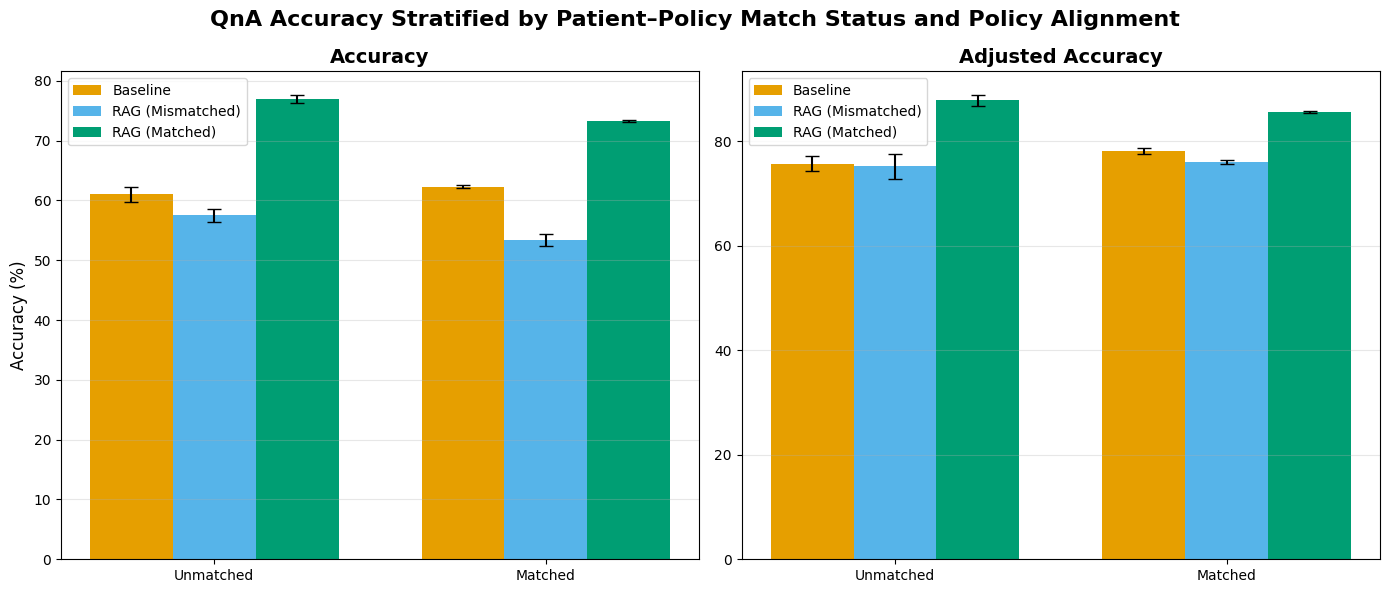

In [36]:
data = summary_iter.reset_index()

# matched=0 (unmatched), matched=1 (matched)로 분리
unmatched_data = data[data['matched'] == 0].sort_values('mode_case')
matched_data = data[data['matched'] == 1].sort_values('mode_case')

# Color-blind friendly colors
color_baseline = '#E69F00'      # Orange
color_rag_incorrect = '#56B4E9' # Sky Blue
color_rag_correct = '#009E73'   # Green

# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('QnA Accuracy Stratified by Patient–Policy Match Status and Policy Alignment', 
             fontsize=16, fontweight='bold')

width = 0.25
x_pos = np.arange(2)  # [Unmatched, Matched]

# === 왼쪽: Accuracy ===
# Baseline
baseline_acc = [unmatched_data[unmatched_data['mode_case']=='baseline']['Avg Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='baseline']['Avg Accuracy (%)'].values[0]]
print(f"Baseline Accuracy: Unmatched={baseline_acc[0]:.2f}, Matched={baseline_acc[1]:.2f}")

baseline_acc_se = [unmatched_data[unmatched_data['mode_case']=='baseline']['Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='baseline']['Accuracy SE'].values[0]]

ax1.bar(x_pos - width, baseline_acc, width,
        yerr=baseline_acc_se, capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'color': 'black', 'linewidth': 1.5})

# RAG Mismatched
rag_incorr_acc = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Avg Accuracy (%)'].values[0],
                  matched_data[matched_data['mode_case']=='rag_all_incorrect']['Avg Accuracy (%)'].values[0]]
print(f"RAG (Mismatched) Accuracy: Unmatched={rag_incorr_acc[0]:.2f}, Matched={rag_incorr_acc[1]:.2f}")

rag_incorr_acc_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Accuracy SE'].values[0],
                     matched_data[matched_data['mode_case']=='rag_all_incorrect']['Accuracy SE'].values[0]]

ax1.bar(x_pos, rag_incorr_acc, width,
        yerr=rag_incorr_acc_se, capsize=5,
        label='RAG (Mismatched)', color=color_rag_incorrect,
        error_kw={'color': 'black', 'linewidth': 1.5})

# RAG Matched
rag_corr_acc = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Avg Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='rag_all_correct']['Avg Accuracy (%)'].values[0]]
print(f"RAG (Matched) Accuracy: Unmatched={rag_corr_acc[0]:.2f}, Matched={rag_corr_acc[1]:.2f}")

rag_corr_acc_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='rag_all_correct']['Accuracy SE'].values[0]]

ax1.bar(x_pos + width, rag_corr_acc, width,
        yerr=rag_corr_acc_se, capsize=5,
        label='RAG (Matched)', color=color_rag_correct,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Unmatched', 'Matched'])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# === 오른쪽: Adjusted Accuracy ===
# Baseline
baseline_adj = [unmatched_data[unmatched_data['mode_case']=='baseline']['Avg Adjusted Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='baseline']['Avg Adjusted Accuracy (%)'].values[0]]
baseline_adj_se = [unmatched_data[unmatched_data['mode_case']=='baseline']['Adjusted Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='baseline']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos - width, baseline_adj, width,
        yerr=baseline_adj_se, capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'color': 'black', 'linewidth': 1.5})

# RAG Mismatched
rag_incorr_adj = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Avg Adjusted Accuracy (%)'].values[0],
                  matched_data[matched_data['mode_case']=='rag_all_incorrect']['Avg Adjusted Accuracy (%)'].values[0]]
rag_incorr_adj_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Adjusted Accuracy SE'].values[0],
                     matched_data[matched_data['mode_case']=='rag_all_incorrect']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos, rag_incorr_adj, width,
        yerr=rag_incorr_adj_se, capsize=5,
        label='RAG (Mismatched)', color=color_rag_incorrect,
        error_kw={'color': 'black', 'linewidth': 1.5})

# RAG Matched
rag_corr_adj = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Avg Adjusted Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='rag_all_correct']['Avg Adjusted Accuracy (%)'].values[0]]
rag_corr_adj_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Adjusted Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='rag_all_correct']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos + width, rag_corr_adj, width,
        yerr=rag_corr_adj_se, capsize=5,
        label='RAG (Matched)', color=color_rag_correct,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax2.set_title('Adjusted Accuracy', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Unmatched', 'Matched'])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure5.pdf', dpi=300, bbox_inches='tight')
plt.show()

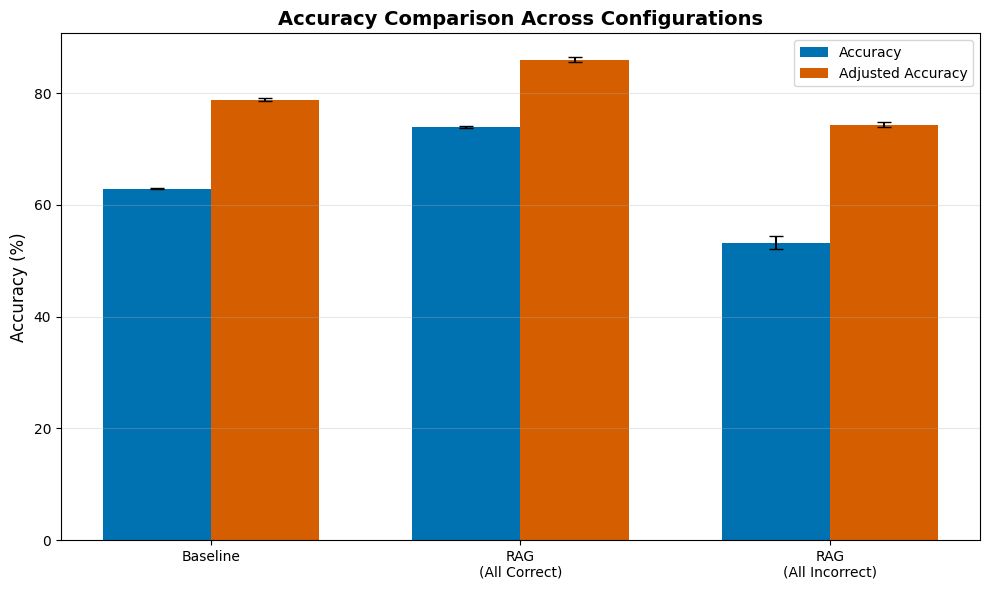

In [14]:
# 데이터 준비
data = summary_iter.reset_index()

# x축 레이블
x_labels = []
for _, row in data.iterrows():
    if row['mode'] == 'baseline':
        x_labels.append('Baseline')
    elif row['case_type'] == 'all_correct':
        x_labels.append('RAG\n(All Correct)')
    else:
        x_labels.append('RAG\n(All Incorrect)')

x_pos = np.arange(len(x_labels))
width = 0.35

# Color-blind friendly colors
color_accuracy = '#0072B2'  # Blue
color_adjusted = '#D55E00'  # Orange

# Figure 생성
fig, ax = plt.subplots(figsize=(10, 6))

# Avg Accuracy
ax.bar(x_pos - width/2, data['Avg Accuracy (%)'], width,
       yerr=data['Accuracy SE'], capsize=5,
       label='Accuracy', color=color_accuracy,
       error_kw={'color': 'black', 'linewidth': 1.5})

# Avg Adjusted Accuracy
ax.bar(x_pos + width/2, data['Avg Adjusted Accuracy (%)'], width,
       yerr=data['Adjusted Accuracy SE'], capsize=5,
       label='Adjusted Accuracy', color=color_adjusted,
       error_kw={'color': 'black', 'linewidth': 1.5})

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Comparison Across Configurations', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
filtered_df = df_merged[
    ((df_merged['mode'] == 'rag') & (df_merged['case_type'] == 'all_correct') & (df_merged['matched'] == 1)) |
    ((df_merged['mode'] == 'rag') & (df_merged['case_type'] == 'all_incorrect') & (df_merged['matched'] == 0)) |
    (df_merged['mode'] == 'baseline')
]

summary2_sample = filtered_df.groupby(['mode', 'matched', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se], 
    'not_answerable_count': 'sum'
}).round(2)
summary2_sample.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                           'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                           'Adjusted Total', 'Adjusted Total SE',
                           'Total Not Answerable']
print(summary2_sample)

                            Count  Avg Accuracy (%)  Accuracy SE  \
mode     matched iteration                                         
baseline 0       iter1         19             63.16         2.56   
                 iter2         19             59.06         2.26   
                 iter3         19             60.82         2.60   
         1       iter1         86             61.89         1.54   
                 iter2         86             62.92         1.58   
                 iter3         86             62.14         1.50   
rag      0       iter1         19             57.89         3.66   
                 iter2         19             55.56         3.70   
                 iter3         19             59.06         3.30   
         1       iter1         86             72.87         1.63   
                 iter2         86             73.39         1.63   
                 iter3         86             73.64         1.73   

                            Avg Adjusted Accura

In [12]:
iter_means2 = filtered_df.groupby(['mode', 'matched', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': 'mean',
    'adjusted_accuracy': 'mean',
    'adjusted_total': 'mean',
    'not_answerable_count': 'sum'
})

summary2_iter = iter_means2.groupby(['mode', 'matched']).agg({
    'case_id': 'sum',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)
summary2_iter.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                         'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                         'Adjusted Total', 'Adjusted Total SE',
                         'Total Not Answerable']
print(summary2_iter)

                  Count  Avg Accuracy (%)  Accuracy SE  \
mode     matched                                         
baseline 0           57             61.01         1.19   
         1          258             62.32         0.31   
rag      0           57             57.50         1.03   
         1          258             73.30         0.23   

                  Avg Adjusted Accuracy (%)  Adjusted Accuracy SE  \
mode     matched                                                    
baseline 0                            75.76                  1.45   
         1                            78.17                  0.51   
rag      0                            75.20                  2.35   
         1                            85.60                  0.26   

                  Adjusted Total  Adjusted Total SE  Total Not Answerable  
mode     matched                                                           
baseline 0                  4.75               0.05                     4  
        

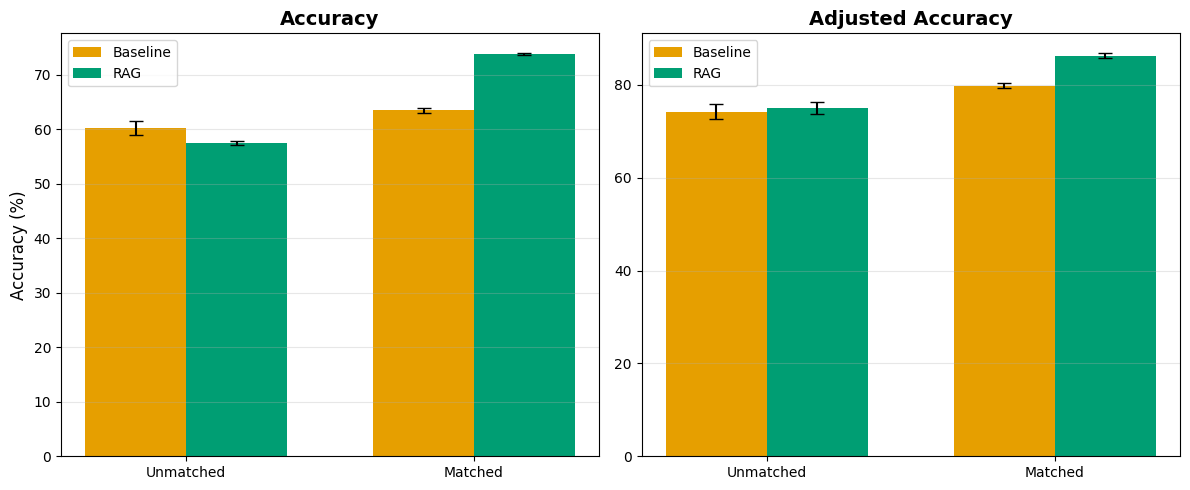

In [19]:
data = summary2_iter.reset_index()

# Baseline/RAG로 분리
baseline_data = data[data['mode'] == 'baseline'].sort_values('matched')
rag_data = data[data['mode'] == 'rag'].sort_values('matched')

# Color-blind friendly colors
color_baseline = '#E69F00'  # Orange
color_rag = '#009E73'  # Green

# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

width = 0.35
x_pos = np.arange(2)  # [Unmatched, Matched]

# === 왼쪽: Accuracy ===
ax1.bar(x_pos - width/2, baseline_data['Avg Accuracy (%)'], width,
        yerr=baseline_data['Accuracy SE'], capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax1.bar(x_pos + width/2, rag_data['Avg Accuracy (%)'], width,
        yerr=rag_data['Accuracy SE'], capsize=5,
        label='RAG', color=color_rag,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Unmatched', 'Matched'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# === 오른쪽: Adjusted Accuracy ===
ax2.bar(x_pos - width/2, baseline_data['Avg Adjusted Accuracy (%)'], width,
        yerr=baseline_data['Adjusted Accuracy SE'], capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax2.bar(x_pos + width/2, rag_data['Avg Adjusted Accuracy (%)'], width,
        yerr=rag_data['Adjusted Accuracy SE'], capsize=5,
        label='RAG', color=color_rag,
        error_kw={'color': 'black', 'linewidth': 1.5})

ax2.set_title('Adjusted Accuracy', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Unmatched', 'Matched'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
import json
with open('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/final_ground_truth.json', 'r') as f:
    ground_truth = json.load(f)

def calc_question_accuracy(df, ground_truth, questions):
    basic_acc = {}
    adjusted_acc = {}
    
    for q in questions:
        answer_col = f'{q}_answer'
        
        # Basic accuracy
        correct = 0
        total = 0
        
        # Adjusted accuracy
        adj_correct = 0
        adj_total = 0
        
        excluded = ["Not Specified", "Question Unclear", "Not Answerable"]
        
        for _, row in df.iterrows():
            case_id = row['case_id']
            if case_id not in ground_truth:
                continue
            
            pred = str(row[answer_col]).strip()
            true = str(ground_truth[case_id][q]).strip()
            
            # Basic
            total += 1
            if pred == true:
                correct += 1
            
            # Adjusted
            if true not in excluded and pred not in excluded:
                adj_total += 1
                if pred == true:
                    adj_correct += 1
        
        basic_acc[q] = (correct / total * 100) if total > 0 else 0
        adjusted_acc[q] = (adj_correct / adj_total * 100) if adj_total > 0 else 0
    
    return basic_acc, adjusted_acc  

def add_value_labels(ax, bars):
    for bar in bars:
        width_val = bar.get_width()
        ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                f'{width_val:.1f}', 
                ha='left', va='center', fontsize=8)

In [21]:
questions = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']
q_labels = ['Q0: Test', 'Q1: Age', 'Q2: Provider', 'Q3: Medical-Necessity', 
            'Q4: Pre-Tests', 'Q5: Family-History', 'Q6: Genetic-Counseling', 
            'Q7: CPT-Code', 'Q8: Decision']

matched_baseline = filtered_df[(filtered_df['mode'] == 'baseline') & (filtered_df['matched'] == 1)]
matched_rag = filtered_df[(filtered_df['mode'] == 'rag') & (filtered_df['matched'] == 1)]
unmatched_baseline = filtered_df[(filtered_df['mode'] == 'baseline') & (filtered_df['matched'] == 0)]
unmatched_rag = filtered_df[(filtered_df['mode'] == 'rag') & (filtered_df['matched'] == 0)]

In [22]:
mb_basic, mb_adj = calc_question_accuracy(matched_baseline, ground_truth, questions)
mr_basic, mr_adj = calc_question_accuracy(matched_rag, ground_truth, questions)
umb_basic, umb_adj = calc_question_accuracy(unmatched_baseline, ground_truth, questions)
umr_basic, umr_adj = calc_question_accuracy(unmatched_rag, ground_truth, questions)

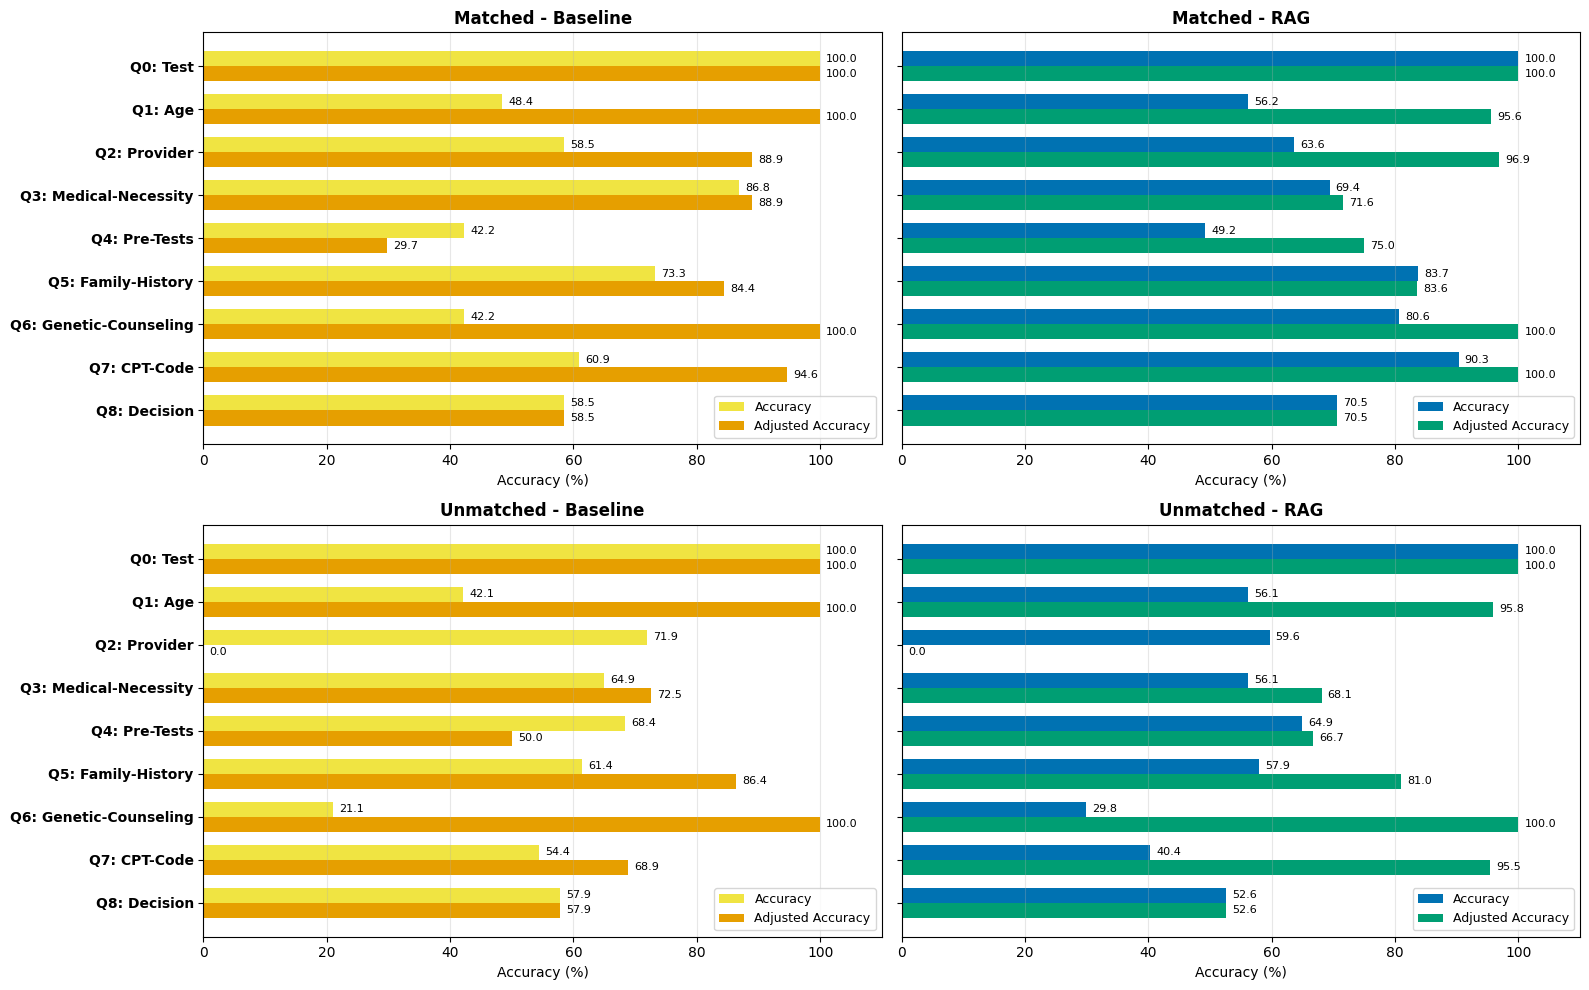

In [ ]:
# Figure 생성
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Question-wise Accuracy Comparison', 
             fontsize=16, fontweight='bold')

# Color-blind friendly colors (새로운 조합)
color_baseline_light = '#F0E442'  # Yellow (basic)
color_baseline_dark = '#E69F00'   # Orange (adjusted)
color_rag_light = '#0072B2'       # Blue (basic)
color_rag_dark = '#009E73'        # Bluish Green (adjusted)

y_pos = np.arange(len(questions))
width = 0.35

# Matched-Baseline
ax = axes[0, 0]
bars1 = ax.barh(y_pos - width/2, [mb_basic[q] for q in questions], width, 
                label='Accuracy', color=color_baseline_light)
bars2 = ax.barh(y_pos + width/2, [mb_adj[q] for q in questions], width, 
                label='Adjusted Accuracy', color=color_baseline_dark)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.set_yticks(y_pos)
ax.set_yticklabels(q_labels, fontweight='bold')
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('Matched - Baseline', fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Matched-RAG
ax = axes[0, 1]
bars1 = ax.barh(y_pos - width/2, [mr_basic[q] for q in questions], width, 
                label='Accuracy', color=color_rag_light)
bars2 = ax.barh(y_pos + width/2, [mr_adj[q] for q in questions], width, 
                label='Adjusted Accuracy', color=color_rag_dark)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.set_yticks(y_pos)
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('Matched - RAG', fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Unmatched-Baseline
ax = axes[1, 0]
bars1 = ax.barh(y_pos - width/2, [umb_basic[q] for q in questions], width, 
                label='Accuracy', color=color_baseline_light)
bars2 = ax.barh(y_pos + width/2, [umb_adj[q] for q in questions], width, 
                label='Adjusted Accuracy', color=color_baseline_dark)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.set_yticks(y_pos)
ax.set_yticklabels(q_labels, fontweight='bold')
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('Unmatched - Baseline', fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Unmatched-RAG
ax = axes[1, 1]
bars1 = ax.barh(y_pos - width/2, [umr_basic[q] for q in questions], width, 
                label='Accuracy', color=color_rag_light)
bars2 = ax.barh(y_pos + width/2, [umr_adj[q] for q in questions], width, 
                label='Adjusted Accuracy', color=color_rag_dark)
add_value_labels(ax, bars1)
add_value_labels(ax, bars2)
ax.set_yticks(y_pos)
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)')
ax.set_title('Unmatched - RAG', fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

plt.tight_layout()
plt.savefig('figure6.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
summary3 = df_merged.groupby(['mode', 'case_type', 'iteration', 'matched']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary3.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                    'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                    'Total Not Answerable']
print(summary3)

                                           Count  Avg Accuracy (%)  \
mode     case_type      iteration matched                            
baseline without_policy iter1     0           19             61.99   
                                  1           86             62.92   
                        iter2     0           19             57.89   
                                  1           86             64.21   
                        iter3     0           19             60.82   
                                  1           86             63.18   
rag      all_correct    iter1     0           19             73.68   
                                  1           86             73.90   
                        iter2     0           19             74.27   
                                  1           86             73.39   
                        iter3     0           19             76.02   
                                  1           86             73.90   
         all_incorre

In [ ]:
summary4 = df_merged.groupby(['mode', 'case_type', 'matched']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary4.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                    'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                    'Total Not Answerable']
print(summary4)

                                 Count  Avg Accuracy (%)  Accuracy SE  \
mode     case_type      matched                                         
baseline without_policy 0           57             60.23         1.71   
                        1          258             63.44         0.86   
rag      all_correct    0           57             74.66         2.48   
                        1          258             73.73         0.90   
         all_incorrect  0           57             57.50         2.05   
                        1          258             52.28         1.22   

                                 Avg Adjusted Accuracy (%)  \
mode     case_type      matched                              
baseline without_policy 0                            74.24   
                        1                            79.86   
rag      all_correct    0                            84.25   
                        1                            86.30   
         all_incorrect  0                  

In [ ]:
filtered_df = df_merged[
    ((df_merged['mode'] == 'rag') & (df_merged['case_type'] == 'all_correct') & (df_merged['matched'] == 1)) |
    ((df_merged['mode'] == 'rag') & (df_merged['case_type'] == 'all_incorrect') & (df_merged['matched'] == 0)) |
    (df_merged['mode'] == 'baseline')
]

# Groupby
summary5 = filtered_df.groupby(['mode', 'matched']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary5.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                    'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                    'Total Not Answerable']
print(summary5)

                  Count  Avg Accuracy (%)  Accuracy SE  \
mode     matched                                         
baseline 0           57             60.23         1.71   
         1          258             63.44         0.86   
rag      0           57             57.50         2.05   
         1          258             73.73         0.90   

                  Avg Adjusted Accuracy (%)  Adjusted Accuracy SE  \
mode     matched                                                    
baseline 0                            74.24                  2.83   
         1                            79.86                  0.98   
rag      0                            75.08                  2.86   
         1                            86.30                  0.95   

                  Total Not Answerable  
mode     matched                        
baseline 0                           4  
         1                          11  
rag      0                           6  
         1                     

In [13]:
# Groupby
summary6 = filtered_df.groupby(['mode', 'iteration', 'matched']).agg({
    'case_id': 'count',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'not_answerable_count': 'sum'
}).round(2)

summary6.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                    'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                    'Total Not Answerable']
print(summary6)

                            Count  Avg Accuracy (%)  Accuracy SE  \
mode     iteration matched                                         
baseline iter1     0           19             61.99         3.21   
                   1           86             62.92         1.49   
         iter2     0           19             57.89         2.63   
                   1           86             64.21         1.52   
         iter3     0           19             60.82         3.11   
                   1           86             63.18         1.45   
rag      iter1     0           19             57.89         3.76   
                   1           86             73.90         1.56   
         iter2     0           19             56.73         3.59   
                   1           86             73.39         1.53   
         iter3     0           19             57.89         3.46   
                   1           86             73.90         1.60   

                            Avg Adjusted Accura